# Value at Risk Methods

## import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import datetime
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import quandl

## import Apple stock value

In [2]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2018-01-01')
aapl = quandl.get('WIKI/AAPL',start_date=start,end_date=end)
aapl.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,17633200.0,0.0,1.0,27.428730,27.566240,27.293790,27.503268,123432400.0
2010-01-05,214.60,215.59,213.25,214.38,21496600.0,0.0,1.0,27.579091,27.706320,27.405597,27.550818,150476200.0
2010-01-06,214.38,215.23,210.75,210.97,19720000.0,0.0,1.0,27.550818,27.660055,27.084312,27.112585,138040000.0
2010-01-07,211.75,212.00,209.05,210.58,17040400.0,0.0,1.0,27.212826,27.244955,26.865839,27.062465,119282800.0
2010-01-08,210.30,212.00,209.06,211.98,15986100.0,0.0,1.0,27.026481,27.244955,26.867124,27.242385,111902700.0


In [3]:
aapl.tail(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-12-22,174.68,175.424,174.500,175.01,16052615.0,0.0,1.0,174.68,175.424,174.500,175.01,16052615.0
2017-12-26,170.80,171.470,169.679,170.57,32968167.0,0.0,1.0,170.80,171.470,169.679,170.57,32968167.0
2017-12-27,170.10,170.780,169.710,170.60,21672062.0,0.0,1.0,170.10,170.780,169.710,170.60,21672062.0
2017-12-28,171.00,171.850,170.480,171.08,15997739.0,0.0,1.0,171.00,171.850,170.480,171.08,15997739.0
2017-12-29,170.52,170.590,169.220,169.23,25643711.0,0.0,1.0,170.52,170.590,169.220,169.23,25643711.0


Text(0.5,1,'Adj. Close Apple Jan 2010 - Jan 2018')

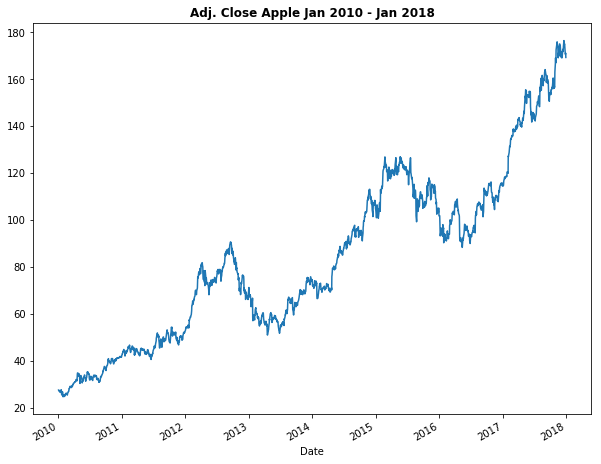

In [4]:
aapl['Adj. Close'].plot(figsize=(10,8))
plt.title('Adj. Close Apple Jan 2010 - Jan 2018', weight='bold')

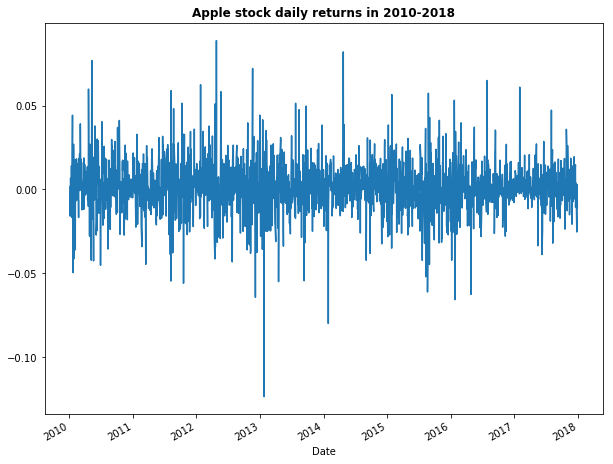

In [5]:
aapl['Adj. Close'].pct_change().plot(figsize=(10,8))
plt.title('Apple stock daily returns in 2010-2018', weight='bold');

## Historical Value at Risk

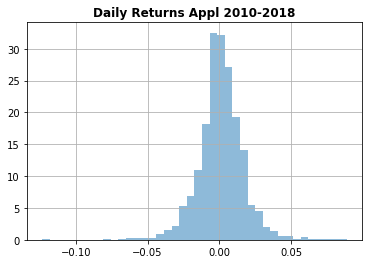

In [6]:
aapl_returns = aapl['Adj. Close'].pct_change().dropna()
mean = aapl_returns.mean()
sigma = aapl_returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(aapl_returns.as_matrix())
aapl_returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.title("Daily Returns Appl 2010-2018", weight='bold');

In [7]:
aapl_returns.quantile(0.05) #daily

-0.02470746197699772

In [8]:
aapl_returns.quantile(0.05)*sqrt(252)

-0.3922187995123214

At 95% confidence, the stock will not exceed a daily loss of 2,47% and a yearly loss of 39,22%

## Covariance - Variance Value at Risk

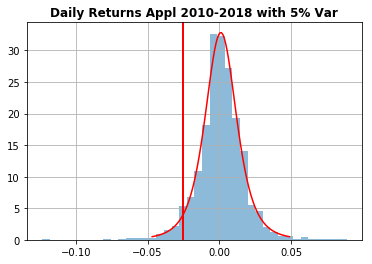

In [9]:
mean=np.mean(aapl_returns)
std_dev = np.std(aapl_returns)
fit = np.linspace(mean-3*std_dev, mean+3*std_dev, 100) # the other would have been to take min and max instead of 99%
q = scipy.stats.norm.ppf(0.05, mean, sigma)
plt.axvline(x=q, linewidth=2, color='r')
aapl_returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(fit, scipy.stats.t.pdf(fit, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title('Daily Returns Appl 2010-2018 with 5% Var', weight='bold');

In [10]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.02519200948382764

In [11]:
scipy.stats.norm.ppf(0.05, mean, sigma)*sqrt(252)

-0.39991075272113147

At 95% confidence, the stock will not exceed a daily loss of 2,51% and a yearly loss of 39,99%. The result are close to the historical method

## CVAR Covariance Variance

In [12]:

0.05**-1 * scipy.stats.norm.pdf(scipy.stats.norm.ppf(0.05))*std_dev - mean

0.0318456593941628

The conditional Var is 3.1845%

## Monte Carlo Value at Risk

In [13]:
# parameters
days = 252    # one year horizon
nbwalks = 1000 # number of walks in the Monte Carlo

mean = np.mean(aapl_returns)
std_dev = np.std(aapl_returns)*sqrt(days)
startprice = aapl['Adj. Close'].iloc[-1] 

dt = 1/float(days)

In [14]:
#creation randon walk funtion
def random_walk(startprice):
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mean * dt, scale=std_dev * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

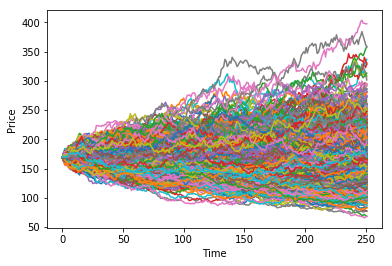

In [15]:
for run in range(nbwalks):
    plt.plot(random_walk(startprice))
plt.xlabel("Time")
plt.ylabel("Price");

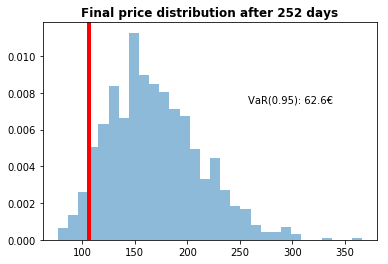

In [17]:
simulations = np.zeros(nbwalks)
for run in range(nbwalks):
    simulations[run] = random_walk(startprice)[days-1]
q = np.percentile(simulations, 5)
plt.hist(simulations, normed=True, bins=30, histtype='stepfilled', alpha=0.5)
plt.axvline(x=q, linewidth=4, color='r')
plt.figtext(0.6, 0.6, u"VaR(0.95): {:.3}€".format(startprice - q))
plt.title(u"Final price distribution after {} days".format(days), weight='bold');

In [18]:
startprice # start price which is the last price of our dataset

169.23

In [19]:
simulations.mean() # mean final price

169.2686669452972

In [21]:
np.percentile(simulations, 5)

106.66934087889962